# Text-Guided Editing of Images (Using CLIP and StyleGAN)

In [1]:
from google.colab import drive
# This will prompt for authorization. This enables to load files stored in your google drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/MyDrive/StyleCLIP-main/StyleCLIP

Mounted at /content/drive/
/content/drive/MyDrive/StyleCLIP-main/StyleCLIP


In [2]:
#@title Setup (may take a few minutes)
#!git clone https://github.com/khalilacheche/StyleCLIP.git

import os
#os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# downloads StyleGAN's weights and facial recognition network weights
ids = ['1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT', '1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL']
for file_id in ids:
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.FetchMetadata(fetch_all=True)
  downloaded.GetContentFile(downloaded.metadata['title'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qis7d0v0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qis7d0v0
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=bf56d15a01293facb8765361f653163c2a18a05b75da44ccb3d565d968b60bda
  Stored in directory: /tmp/pip-ephem-wheel-cache-av2lmx6q/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
experiment_type = 'edit' #@param ['edit', 'free_generation']

semantic_part = "hair" #@param ["mouth","skin","eyes","nose","ears","eye_brows","hat","hair","neck"]

description = 'A person with blue hair' #@param {type:"string"}

latent_path = "/content/drive/MyDrive/StyleCLIP-main/StyleCLIP/latents.pt" #@param {type:"string"}

optimization_steps = 40 #@param {type:"number"}

clip_lambda = 1 #@param {type:"number"}

l2_lambda = 0.000 #@param {type:"number"}

loc_lambda = 0.00001 #@param {type:"number"}

id_lambda = 0.005 #@param {type:"number"}

stylespace = False #@param {type:"boolean"}

create_video = True #@param {type:"boolean"}

export_segmentation_image = True #@param {type:"boolean"}


In [4]:
use_seed = True #@param {type:"boolean"}

seed = 1 #@param {type: "number"}

In [5]:
#@title Additional Arguments
args = {
    "description": description,
    "ckpt": "stylegan2-ffhq-config-f.pt",
    "stylegan_size": 1024,
    "lr_rampup": 0.05,
    "lr": 0.1,
    "step": optimization_steps,
    "mode": experiment_type,
    "clip_lambda": clip_lambda,
    "l2_lambda": l2_lambda,
    "id_lambda": id_lambda,
    "loc_lambda": loc_lambda,
    'work_in_stylespace': stylespace,
    "latent_path": latent_path,
    "truncation": 0.7,
    "save_intermediate_image_every": 1 if create_video else 20,
    "results_dir": "results",
    "ir_se50_weights": "model_ir_se50.pth",
    "segmentation_model": "face_segmentation",
    "semantic_part":semantic_part,
    "export_segmentation_image": export_segmentation_image
}

In [2]:

if use_seed:
  import torch
  torch.manual_seed(seed)
from optimization.run_optimization_ import main
from argparse import Namespace
result = main(Namespace(**args))

ModuleNotFoundError: ignored

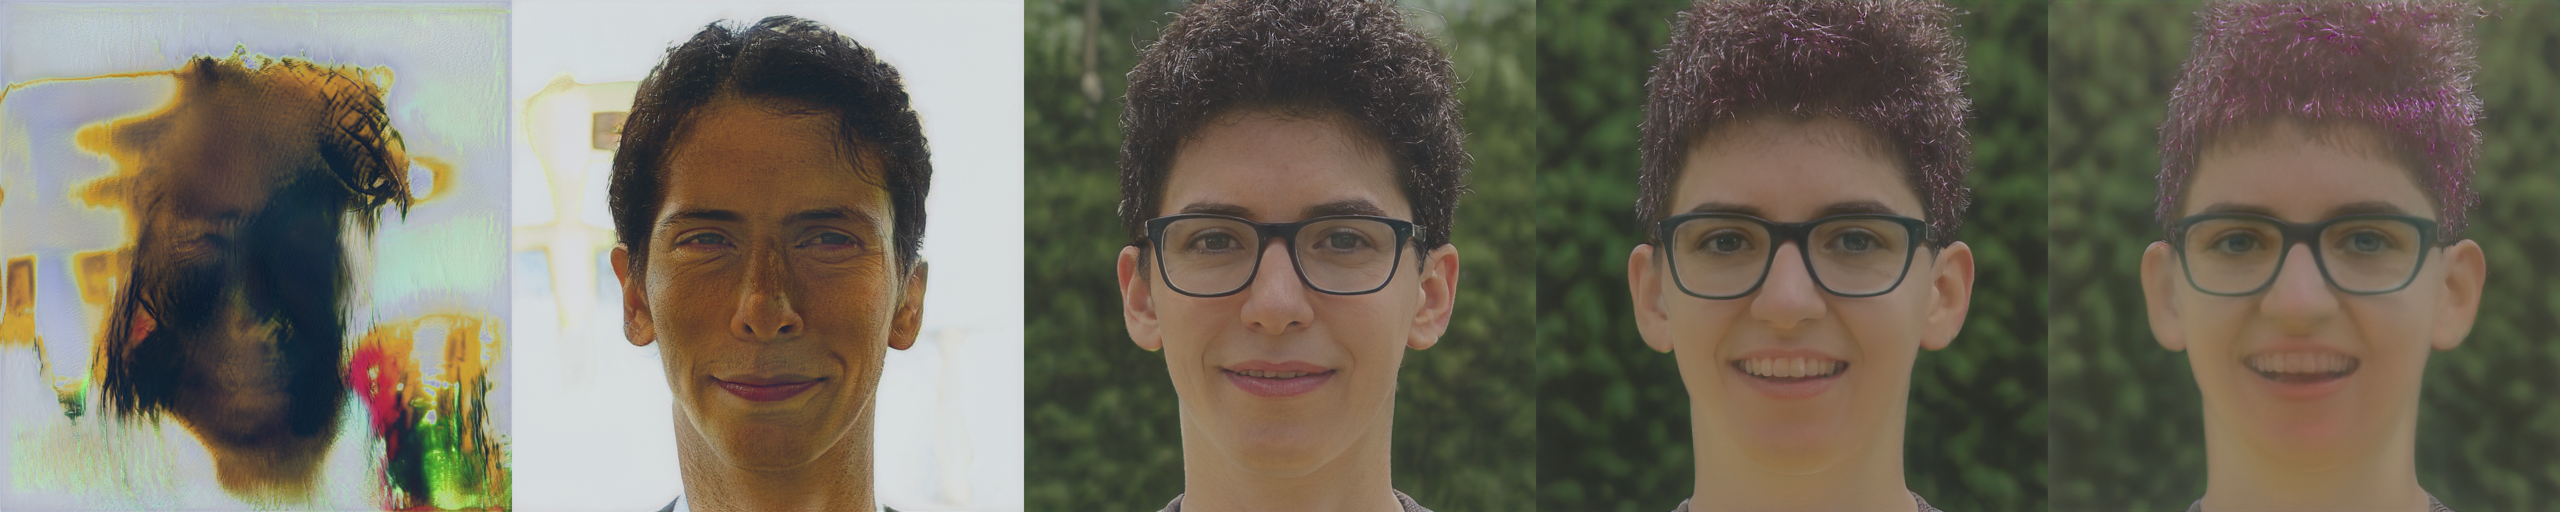

In [7]:
#from left to right, scale factor is -1,-0.5,origin,0.5,1
#@title Visualize Result
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
result_image = ToPILImage()(make_grid(result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [ ]:
#@title Create and Download Video

#!ffmpeg -r 15 -i results/%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
#from google.colab import files
#files.download('out.mp4')